In [1]:
import xarray as xr
import pandas as pd
import os
import numpy as np
import deepsensor
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import deepsensor.torch
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm_notebook
from deepsensor.model import ConvNP
from tqdm import tqdm_notebook
from matplotlib.animation import FuncAnimation, PillowWriter
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.train import set_gpu_default_device, Trainer

In [2]:
set_gpu_default_device()

#### Reading data files and merging them to form an xarray ds

In [3]:
def extract_timestamp(file):
    return np.datetime64(f'{file[-9:-5]}-{file[-5:-3]}-01 00:00:00.000000000','ns')

combined_ds = []
dir_path = 'Monthly_01'
for folder in os.listdir(dir_path):
    for file in os.listdir(f'{dir_path}/{folder}'):
        monthly_ds = xr.open_dataset(os.path.join(dir_path,folder,file))
        timestamp = extract_timestamp(file)
        combined_ds.append(monthly_ds.expand_dims({'Timestamp':[timestamp]}))
wustl_monthly_ds = xr.concat(combined_ds,dim='Timestamp').sortby('Timestamp')

wustl_monthly_ds = wustl_monthly_ds.sel(Timestamp = slice("1998","2019"))   # Removing covid affected years 

In [4]:
wustl = wustl_monthly_ds.copy()
wustl

<xarray.Dataset> Size: 591MB
Dimensions:    (Timestamp: 264, lat: 700, lon: 800)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2kB 1998-01-01 ... 2019-12-01
  * lat        (lat) float32 3kB -9.95 -9.85 -9.75 -9.65 ... 59.75 59.85 59.95
  * lon        (lon) float32 3kB 65.05 65.15 65.25 65.35 ... 144.8 144.9 144.9
Data variables:
    PM25       (Timestamp, lat, lon) float32 591MB 1.666 1.7 ... 1.425 1.386
Attributes:
    TITLE:            Convolutional Neural Network Monthly PM2.5 Estimation o...
    CONTACT:          SIYUAN SHEN <s.siyuan@wustl.edu>
    LAT_DELTA:        0.1
    LON_DELTA:        0.1
    SPATIALCOVERAGE:  AS
    TIMECOVERAGE:     201206

#### Visualising the data

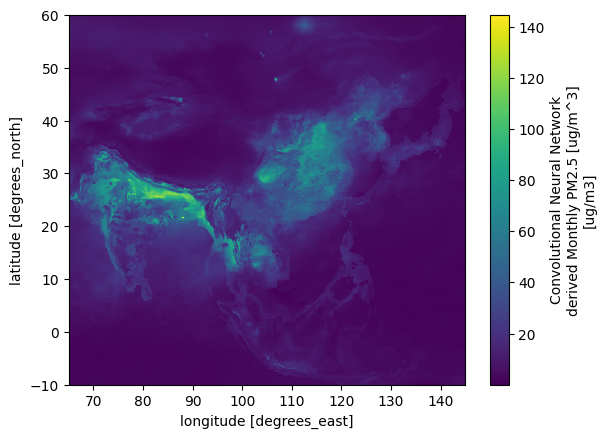

In [5]:
random_file = xr.open_dataset('/home/vinayakrana/ActiveAir/AQ-SensorPlacement/Monthly_01/1998/V6GL02.02.0p10.CNNPM25.AS.199801-199801.nc')
data_to_visualise = random_file['PM25']
data_to_visualise.plot()

#### Visualising a GIF over timestep

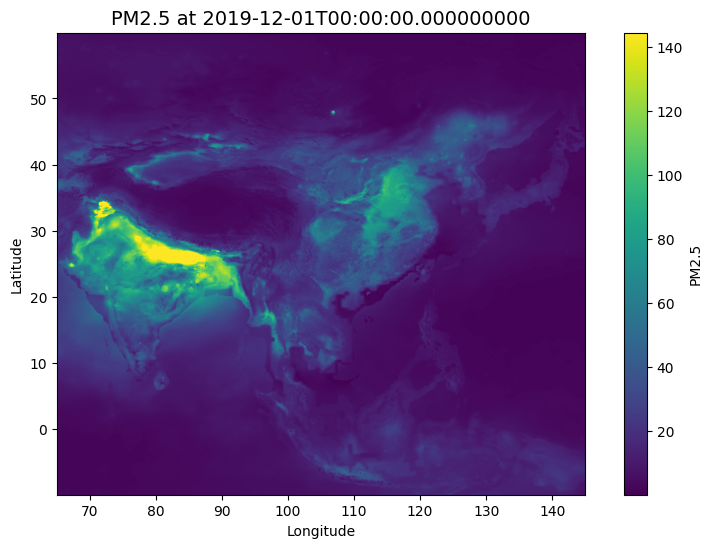

In [6]:
dataset = wustl.copy()
data_to_visualise = dataset['PM25']

timestamps = dataset['Timestamp'].values
latitudes = dataset['lat'].values
longitudes = dataset['lon'].values

fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the plot
plot = ax.imshow(
    data_to_visualise.isel(Timestamp=0),
    extent=[longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()],
    cmap='viridis',
    origin='lower',
)
ax.set_title(f"PM2.5 at {timestamps[0]}", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.colorbar(plot, ax=ax, label="PM2.5")

# Update function for the animation
def update(frame):
    plot.set_data(data_to_visualise.isel(Timestamp=frame))
    ax.set_title(f"PM2.5 at {timestamps[frame]}", fontsize=14)
    return [plot]

anim = FuncAnimation(
    fig, update, frames=len(timestamps), interval=200, blit=True
)

# Save the animation 
output_file = "pm25_timeseries_animation.gif"
anim.save(output_file, writer=PillowWriter(fps=10))

In [5]:
df = wustl.to_dataframe()
# temp4 = temp.dropna(subset=['PM25'])

In [6]:
df

PM25
Timestamp  lat        lon                 
1998-01-01 -9.950000  65.050003   1.666000
                      65.150002   1.700000
                      65.250000   1.658000
                      65.349998   1.698000
                      65.449997   1.618000
...                                    ...
2019-12-01  59.950001 144.550003  1.352360
                      144.649994  1.406487
                      144.750000  1.442034
                      144.850006  1.425182
                      144.949997  1.386380

[147840000 rows x 1 columns]

In [7]:
df_reset = df.reset_index()

In [8]:
# Read geojson file for indian boundary

if os.path.exists("filtered_points.geojson"):
    # If file already exists, then read it directly
    print('File found')
    filtered_points = gpd.read_file("filtered_points.geojson")

else:
    india = gpd.read_file("/home/vinayakrana/ActiveAir/AQ-SensorPlacement/india_India_Country_Boundary.geojson/india_India_Country_Boundary.geojson").to_crs("EPSG:3857")
    india_buffer = india.buffer(100000) # create a buffer of 100 Km
    geometry = [Point(lon, lat) for lon, lat in zip(df_reset['lon'], df_reset['lat'])]
    gdf_points = gpd.GeoDataFrame(df_reset, geometry=geometry, crs='EPSG:4326')

    india_buffer_wgs84 = gpd.GeoDataFrame(geometry=india_buffer, crs="EPSG:3857").to_crs("EPSG:4326")
    filtered_points = gpd.sjoin(gdf_points, india_buffer_wgs84, how='inner', predicate='intersects')

    filtered_points.to_file("filtered_points.geojson", driver="GeoJSON")
india = gpd.read_file("/home/vinayakrana/ActiveAir/AQ-SensorPlacement/india_India_Country_Boundary.geojson/india_India_Country_Boundary.geojson").to_crs("EPSG:3857")
india_buffer = india.buffer(100000) # create a buffer of 100 Km

File found


In [9]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


Text(0.5, 1.0, 'Indian Map')

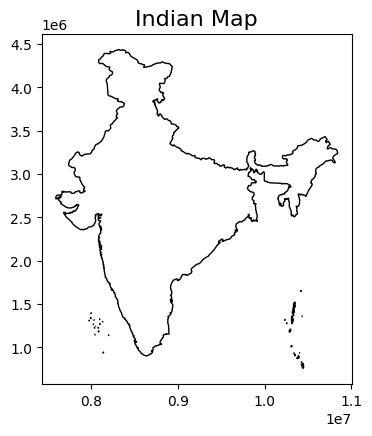

In [10]:
# Plotting the geojson file of indian boundary
fig, axis = plt.subplots(figsize=(4,6))
india.plot(ax=axis,color='none')
plt.title('Indian Map',fontsize=16)

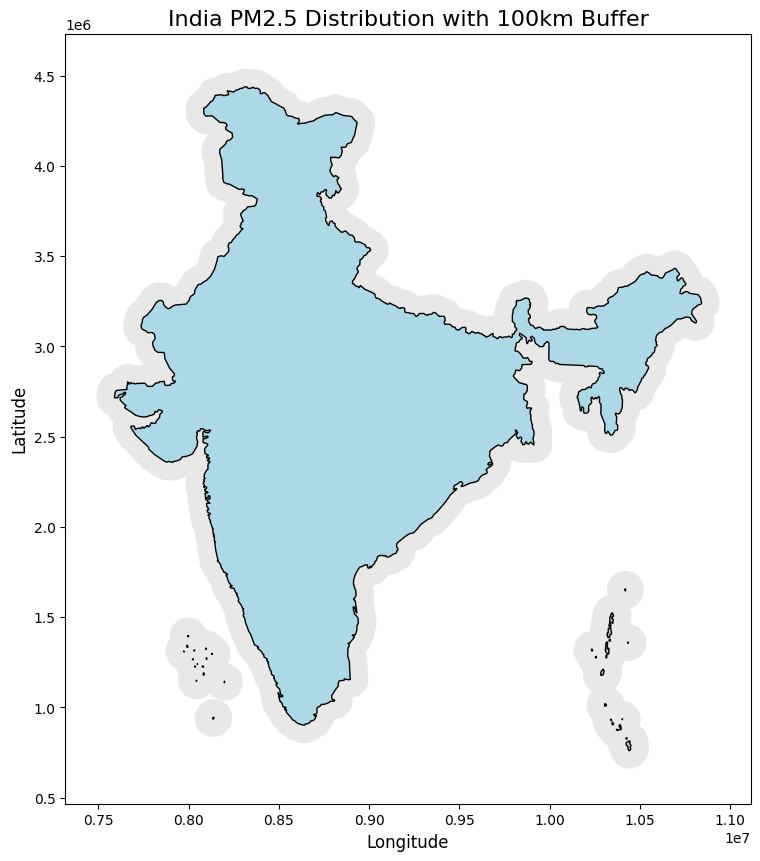

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the India boundary and buffer
india_buffer.plot(ax=ax, color='lightgray', alpha=0.5)  # Buffer
india.plot(ax=ax, color='lightblue', edgecolor='black')  # India boundary

# Add title and labels
plt.title("India PM2.5 Distribution with 100km Buffer", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

# Display the plot
plt.show()

In [12]:
# Change the data into the required format
df_india = filtered_points.drop(['geometry', 'index_right'],axis=1)

# Set the timestamp, lat, and lon to indices
df_india.set_index(['Timestamp','lat','lon'],inplace=True)
df_india

PM25
Timestamp  lat       lon                 
1998-01-01 5.950000  93.650002   6.791001
                     93.750000   6.494000
                     93.849998   6.150000
                     93.949997   5.735000
           6.050000  93.349998   7.667000
...                                   ...
2019-12-01 37.650002 74.949997   8.786961
                     75.050003   8.689709
                     75.150002   8.235176
                     75.250000  10.065813
                     75.349998  12.718843

[11537064 rows x 1 columns]

##### Train-validation-Test Split
* Total years = 22 (1998 - 2019)
* Train + validation = 13 years
* Active learning = 5 years
* Test = 4 years

In [13]:
train_val_start, train_val_end = "1998-01-01", "2010-12-01"
activeL_start, activeL_end     = "2011-01-01", "2015-12-01"
test_start, test_end           = "2016-01-01", "2019-12-01" 

train_start, train_end         = "1998-01-01", "2007-12-01"
val_start, val_end             = "2008-01-01", "2010-12-01"  

In [14]:
train_val_df       = df_india.loc[train_val_start:train_val_end]
activeLearning_df = df_india.loc[activeL_start:activeL_end]
test_df           = df_india.loc[test_start:test_end]

In [15]:
# Divide train and val data
# train_df = df_india.loc[train_start:train_end]
# val_df   = df_india.loc[val_start:val_end]

In [16]:
data_processor = DataProcessor(time_name='Timestamp',x1_name="lat",x2_name='lon')
train_val_normalized = data_processor(train_val_df)
train_val_normalized

PM25
time       x1       x2                
1998-01-01 0.000000 0.829653 -1.073483
                    0.832808 -1.085793
                    0.835962 -1.100050
                    0.839117 -1.117250
           0.003155 0.820189 -1.037177
...                                ...
2010-12-01 1.000000 0.239748 -0.816454
                    0.242902 -0.793234
                    0.246057 -0.814286
                    0.249211 -0.843003
                    0.252366 -0.781781

[6817356 rows x 1 columns]

### Manually calculating the internal data density from xarray 
(Refer to the link for implementation details- https://github.com/alan-turing-institute/deepsensor/blob/main/deepsensor/data/utils.py#L77)

In [17]:
train_val_normalized_ds = train_val_normalized.to_xarray() # converting to xarray dataset
train_val_normalized_ds

/home/vinayakrana/.local/lib/python3.10/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return xarray.Dataset.from_dataframe(self)
/home/vinayakrana/.local/lib/python3.10/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the

<xarray.Dataset> Size: 123MB
Dimensions:  (time: 156, x1: 318, x2: 310)
Coordinates:
  * time     (time) datetime64[ns] 1kB 1998-01-01 1998-02-01 ... 2010-12-01
  * x1       (x1) float64 3kB 0.0 0.003155 0.006309 ... 0.9937 0.9968 1.0
  * x2       (x2) float64 2kB 0.0 0.003155 0.006309 ... 0.9685 0.9716 0.9748
Data variables:
    PM25     (time, x1, x2) float64 123MB nan nan nan nan ... nan nan nan nan

In [18]:
x1_res = np.abs(np.mean(np.diff(train_val_normalized_ds['x1'])))
x2_res = np.abs(np.mean(np.diff(train_val_normalized_ds['x2'])))

data_resolution = float(np.min([x1_res, x2_res]))
data_density = int(1/data_resolution)

In [19]:
task_loader = TaskLoader(context=train_val_normalized, target=train_val_normalized)
task_loader.load_dask()
print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('PM25',),)
Target variable IDs: (('PM25',),)


In [20]:
if os.path.exists("deepsensor_config"):
    model = ConvNP(data_processor, task_loader,"deepsensor_config/") 
    print("Model found")
else:
    model = ConvNP(data_processor, task_loader,internal_density = data_density, unet_channels=(32, 32, 32, 32, 32)) 

Model found


/home/vinayakrana/.local/lib/python3.10/site-packages/deepsensor/model/convnp.py:359: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(os.

In [21]:
# train_range = ("1998-01-01","2018-01-01")
# val_range = ("2019-01-01","2023-01-01")

In [22]:
def gen_tasks(dates):

    """
    Generates tasks for the specified dates
    """

    tasks = []
    for date in dates:
        N_c = np.random.randint(5,501)      # Randomly sampling [0,500] points as context set
        N_t = np.random.randint(3000,5001)  # Randomly sampling [3000,5000] points as target set

        task = task_loader(date, context_sampling = N_c, target_sampling = "all")

        tasks.append(task)

    return tasks

In [23]:
val_dates = pd.date_range(val_start, val_end, freq = 'MS')
val_tasks = gen_tasks(val_dates)

In [24]:
def calculate_val_rmse(model, val_tasks):
    
    errors = []
    tar_var_id = task_loader.target_var_IDs[0][0]
    for task in val_tasks:
        pred = data_processor.map_array(model.mean(task), tar_var_id, unnorm = True)
        true = data_processor.map_array(task['Y_t'][0], tar_var_id, unnorm = True)

        errors.append(np.abs(pred - true))
    
    return np.sqrt(np.mean(np.hstack(errors) ** 2))
    

In [25]:
losses = []
val_rmses = []

In [25]:
val_rmse_best = np.inf
patience = 10
trainer = Trainer(model, lr = 5e-5)

for epoch in tqdm_notebook(range(100)):

    train_dates = pd.date_range(train_start, train_end, freq = "MS")
    train_tasks = gen_tasks(train_dates)
    batch_losses = trainer(train_tasks)

    losses.append(np.mean(batch_losses))
    val_rmses.append(calculate_val_rmse(model, val_tasks))

    if val_rmses[-1] < val_rmse_best:
        patience = 5
        val_rmse_best = val_rmses[-1]
        model.save('deepsensor_config/')
    else:
        patience -= 1    # If there is no improvemnet, reduce the counter by 1
    if patience == 0:
        break            # If there is no improvement uptill 5 epochs, stop the training

/tmp/ipykernel_4025788/3069479108.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

/home/vinayakrana/.local/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


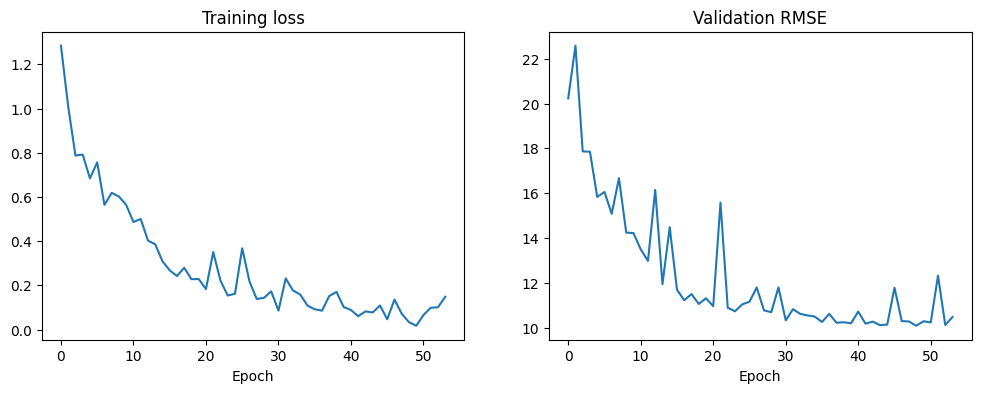

In [26]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

In [26]:
def predict(date, cs):
    
    test_task = task_loader(date, context_sampling = cs)
    pred = model.predict(test_task, X_t = train_val_df.loc['1998-01-01'])

    return pred

In [36]:
pred = predict("2010-10-01", 400)

In [39]:
# date = "2004-01-01"
# test_task = task_loader(date,context_sampling=100)
# pred = model.predict(test_task, X_t=train_val_df.loc['1998-01-01'])
# # fig = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task, crs=ccrs.PlateCarree())

In [40]:
pred[0]

mean        std
time       lat       lon                            
2004-01-01 5.950000  93.650002  23.585789  14.066747
                     93.750000  23.585789  14.066747
                     93.849998  23.585793  14.066747
                     93.949997  23.585793  14.066747
           6.050000  93.349998  23.585735  14.066755
...                                   ...        ...
           37.650002 74.949997  23.585411  14.067028
                     75.050003  23.585423  14.066894
                     75.150002  23.585369   14.06679
                     75.250000  23.585302  14.066722
                     75.349998  23.585243  14.066687

[43701 rows x 2 columns]

In [106]:
df_india.loc['1998-01-01'].reset_index()


,lat,lon,PM25
0,5.950000,93.650002,6.791001
1,5.950000,93.750000,6.494000
2,5.950000,93.849998,6.150000
3,5.950000,93.949997,5.735000
4,6.050000,93.349998,7.667000
...,...,...,...
43696,37.650002,74.949997,6.033436
43697,37.650002,75.050003,6.209253
43698,37.650002,75.150002,6.389035
43699,37.650002,75.250000,7.321677


#### Let's see PM2.5 values for a random day

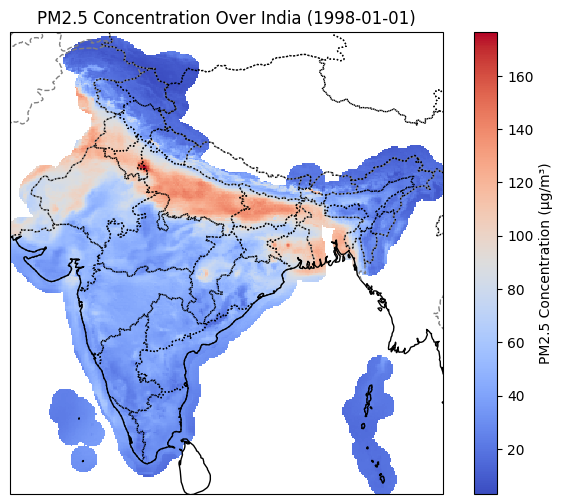

In [28]:
# Define India's bounding box (approximate)
india_extent = [68, 98, 6, 38]  # (min_lon, max_lon, min_lat, max_lat)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})

values = df_india.loc['2015-01-01'].reset_index()
lat, lon, pm25 = values['lat'], values['lon'], values['PM25']

pm25_grid = values.pivot(index='lat', columns='lon', values='PM25')

lon_grid, lat_grid = np.meshgrid(pm25_grid.columns, pm25_grid.index)

c = ax.pcolormesh(lon_grid, lat_grid, pm25_grid.values, cmap='coolwarm', shading='auto')
cbar = plt.colorbar(c, ax=ax, orientation="vertical", label="PM2.5 Concentration (µg/m³)")

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="gray")  
ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="black")   

# Set plot limits to focus on India
ax.set_extent(india_extent, crs=ccrs.PlateCarree())

ax.set_title("PM2.5 Concentration Over India (1998-01-01)")

plt.show()


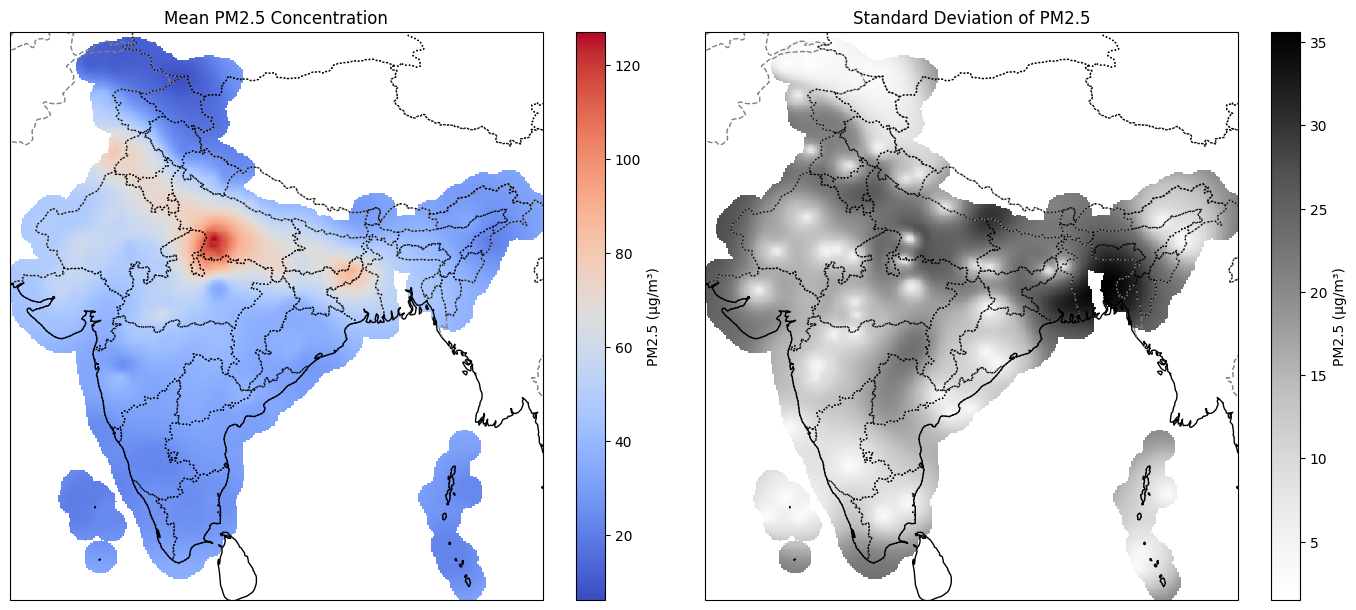

In [38]:
# Define India's bounding box (approximate)
india_extent = [68, 98, 6, 38]  # (min_lon, max_lon, min_lat, max_lat)

# Extract the data
values = pred[0].reset_index()  # Use pred[0] instead of df_india
lat, lon, pm25_mean, pm25_std = values["lat"], values["lon"], values["mean"], values["std"]

# Pivot the data for mean and standard deviation
pm25_mean_grid = values.pivot(index="lat", columns="lon", values="mean").astype(float)
pm25_std_grid = values.pivot(index="lat", columns="lon", values="std").astype(float)

# Keep NaNs as NaNs (don't fill with 0)
pm25_mean_grid = pm25_mean_grid.replace({0: np.nan})  
pm25_std_grid = pm25_std_grid.replace({0: np.nan})

# Create a meshgrid for latitudes and longitudes
lon_grid, lat_grid = np.meshgrid(pm25_mean_grid.columns.astype(float), pm25_mean_grid.index.astype(float))

# Mask NaN values so they are ignored in pcolormesh
pm25_mean_masked = np.ma.masked_invalid(pm25_mean_grid.values)
pm25_std_masked = np.ma.masked_invalid(pm25_std_grid.values)

# Create subplots (1 row × 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Titles and colormaps for the subplots
plot_configs = [
    {"title": "Mean PM2.5 Concentration", "data": pm25_mean_masked, "cmap": "coolwarm"},
    {"title": "Standard Deviation of PM2.5", "data": pm25_std_masked, "cmap": "Greys"},
]

# Loop through subplots
for ax, config in zip(axes, plot_configs):
    c = ax.pcolormesh(lon_grid, lat_grid, config["data"], cmap=config["cmap"], shading="auto")
    plt.colorbar(c, ax=ax, orientation="vertical", label="PM2.5 (µg/m³)")
    
    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="gray")
    ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="black")
    
    # Set plot limits to focus on India
    ax.set_extent(india_extent, crs=ccrs.PlateCarree())
    
    # Set title
    ax.set_title(config["title"])

plt.tight_layout()
plt.show()


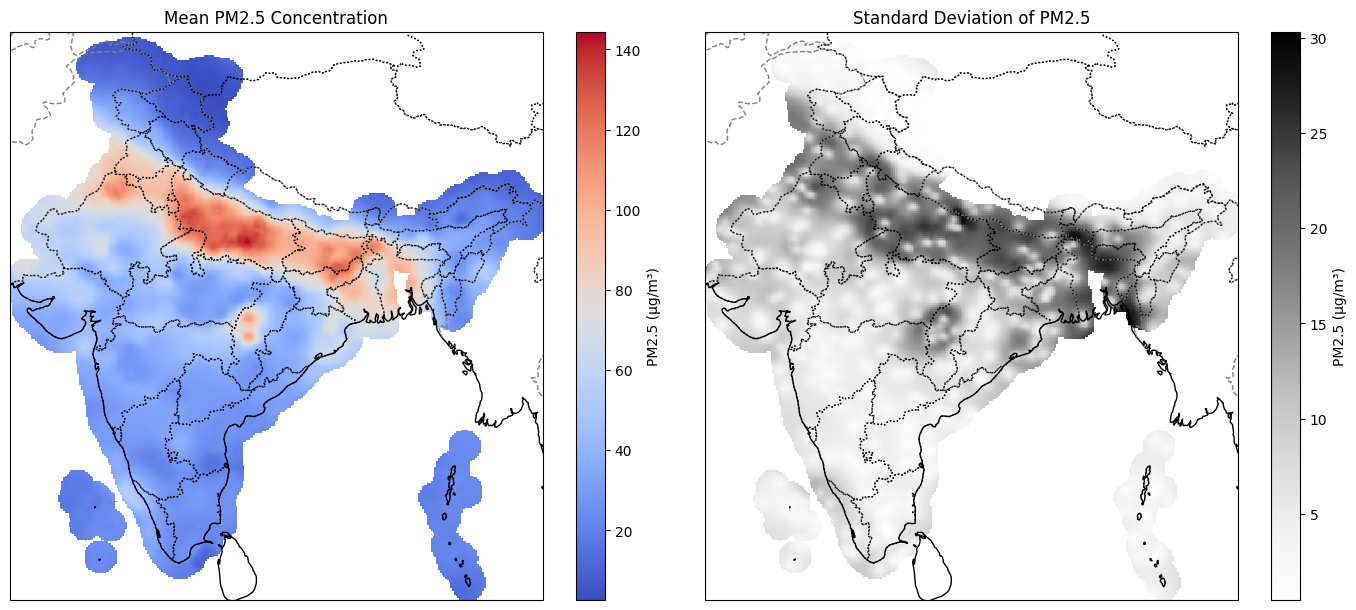

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Define India's bounding box (approximate)
india_extent = [68, 98, 6, 38]  # (min_lon, max_lon, min_lat, max_lat)

# Extract the data
values = pred[0].reset_index()  # Use pred[0] instead of df_india
lat, lon, pm25_mean, pm25_std = values["lat"], values["lon"], values["mean"], values["std"]

# Pivot the data for mean and standard deviation
pm25_mean_grid = values.pivot(index="lat", columns="lon", values="mean").astype(float)
pm25_std_grid = values.pivot(index="lat", columns="lon", values="std").astype(float)

# Keep NaNs as NaNs (don't fill with 0)
pm25_mean_grid = pm25_mean_grid.replace({0: np.nan})  
pm25_std_grid = pm25_std_grid.replace({0: np.nan})

# Create a meshgrid for latitudes and longitudes
lon_grid, lat_grid = np.meshgrid(pm25_mean_grid.columns.astype(float), pm25_mean_grid.index.astype(float))

# Mask NaN values so they are ignored in pcolormesh
pm25_mean_masked = np.ma.masked_invalid(pm25_mean_grid.values)
pm25_std_masked = np.ma.masked_invalid(pm25_std_grid.values)

# Create subplots (1 row × 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Titles and colormaps for the subplots
plot_configs = [
    {"title": "Mean PM2.5 Concentration", "data": pm25_mean_masked, "cmap": "coolwarm"},
    {"title": "Standard Deviation of PM2.5", "data": pm25_std_masked, "cmap": "Greys"},
]

# Loop through subplots
for ax, config in zip(axes, plot_configs):
    c = ax.pcolormesh(lon_grid, lat_grid, config["data"], cmap=config["cmap"], shading="auto")
    plt.colorbar(c, ax=ax, orientation="vertical", label="PM2.5 (µg/m³)")
    
    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="gray")
    ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="black")
    
    # Set plot limits to focus on India
    ax.set_extent(india_extent, crs=ccrs.PlateCarree())
    
    # Set title
    ax.set_title(config["title"])

plt.tight_layout()
plt.show()


#### Let's see how the std varies as we vary the number of context points

In [33]:
context_points = np.arange(0,501,5)
date = "2017-10-01"
stds = []

for point in context_points:
    pred = predict(date,point)
    mean_std = pred[0].reset_index()['std'].mean()
    stds.append(mean_std)

ValueError: a cannot be empty unless no samples are taken